## Testing two different teaching methods.

I participated in a study that looked at whether the order of presenting materials in a high school biology class made a difference in test scores. 

Students were split into two groups; in Group 1, Mendelian genetics was taught before any in-depth discussion of the molecular biology underpinning genetics. In Group 2, the molecular biology was taught before teaching Mendelian genetics. Some teachers have hypothesized that the second method would be better for students; we looked at the evidence with this study.


Note: Every attempt was made to control for all other variables in the two groups; most importantly, they had the same teacher, textbook, and access to materials. Students were randomly placed into a group. However, there were a few things that could not be controlled for- notably, the two groups met on different times of the week.

### Approach:
Here I look at exam score data for the two groups- this exam specifically focused on the conceptual understanding of genetics. 

I use both classical hypothesis testing and Bayesian methods to estimate the difference in the scores between the two groups, and estimate the uncertainty.

In [13]:
%matplotlib inline
np.random.seed(20090425)
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import sys
sys.path.append('../ThinkStats2/code')
from thinkstats2 import HypothesisTest
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")

Functions for data prep.

In [11]:
def get_col_vals(df, col1, col2):
    """
    Get column values 
    """
    y1 = np.array(df[col1])
    y2 = np.array(df[col2])
    return y1, y2

def prep_data(df, col1, col2):
    """
    Prepare data for pymc3 and return mean mu and sigma
    """
    y1 = np.array(df[col1])
    y2 = np.array(df[col2])

    y = pd.DataFrame(dict(value=np.r_[y1, y2], 
                          group=np.r_[[col1]*len(y1), 
                            [col2]*len(y2)]))
    mu = y.value.mean()
    sigma = y.value.std() * 2
    
    return y, mu, sigma

Functions for hypothesis testing by bootstrapping resampling.

In [5]:
class DiffMeansPermute(HypothesisTest):
    """
    Model the null hypothesis, which says that the distributions
    for the two groups are the same.
    data: pair of sequences (one for each group)
    """
    def TestStatistic(self, data):
        """
        Calculate the test statistic, the absolute difference in means
        """
        group1, group2 = data
        test_stat = abs(np.mean(group1) - np.mean(group2))
        return test_stat

    def MakeModel(self):
        """
        Record the sizes of the groups, n and m, 
        and combine into one Numpy array, self.pool
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        
        # make group1 and group2 into a single array
        self.pool = np.concatenate((group1, group2))

    def RunModel(self):
        """
        Simulate the null hypothesis- shuffle the pooled values 
        and split into 2 groups with sizes n and m
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

def Resample(x):
    """
    Get a bootstrap sample
    """
    return np.random.choice(x, len(x), replace=True)

def FalseNegRate(data, num_runs=100):
    """
    Calculate the false negative rate: the chance that the hypothesis 
    test will fail when the effect is real.
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = Resample(group1)
        sample2 = Resample(group2)

        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iters=101)
        
        if pvalue > 0.05:
            count += 1

    return count / num_runs

### The data

In [4]:
scores = pd.read_excel('test_scores.xlsx')

In group1, students were taught the more "traditional" way; they were taught Mendelian genetics before molecular biology. In group2, the order was reversed.

In [6]:
scores.head()

,group1,group2
0,81,90
1,80,90
2,90,85
3,99,83
4,95,74


In [4]:
scores.describe()

,group1,group2
count,93.000000,93.000000
mean,79.000000,81.806452
std,9.639141,8.849291
min,52.000000,60.000000
25%,72.000000,76.000000
50%,79.000000,82.000000
75%,85.000000,88.000000
max,99.000000,99.000000


#### How significant is the difference?

Both groups had 93 students, and the mean for group2 (81.8) is 2.8 points higher than the mean for group1 (79). We can also see that group2's min and standard deviation were lower than group1's min and standard deviation. How significant are these differences?

### Classical hypothesis testing
#### Simulation based:

First we can start with "classical" hypothesis testing and calculate p-values.  
We can do this by: (1) constructing a model of the null hypothesis via simulation or (2) using statsmodel's t-test.

In [14]:
y1, y2 = get_col_vals(scores, 'group1', 'group2')
ht = DiffMeansPermute((y1, y2))

pval=ht.PValue()
pval

0.043

#### T-test:

In [15]:
ttest_ind(y1,y2, equal_var=False)

Ttest_indResult(statistic=-2.0683211848534517, pvalue=0.040018677966763901)

Both give p-values of about .04, so at a cutoff of .05, these tests say the difference is significant. However, this might be a bit borderline. 

### Bayesian
I'll also Bayesian methods to estimate how different the scores were between the two groups, and estimate the uncertainty.

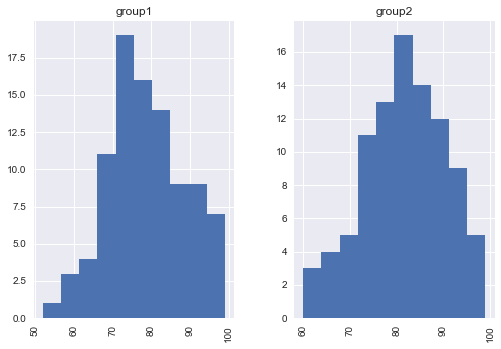

In [10]:
y, mu, sigma = prep_data(scores, 'group1', 'group2')
y.hist('value', by='group');

I'll use a t-distribution (this is less sensitive to outliers compared to the normal distribution) to describe the distribution of scores for each group, with each having its own mean and standard deviation parameter. I'll use the same ν (the degrees of freedom parameter) for the two groups- so here we are making an assumption that the degree of normality is roughly the same for the two groups.

So the description of the data uses five parameters: the means of the two groups, the standard deviations of the two groups, and ν.

I'll apply broad normal priors for the means. The hyperparameters are arbitrarily set to the pooled empirical mean of the data and 2 times the pooled empirical standard deviation; this just applies very "diffuse" information to these quantities.

### Sampling from the posterior

In [6]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    """
    The priors for each group.
    """
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

I'll give a uniform(1,20) prior for the standard deviations. 

In [7]:
σ_low = 1
σ_high = 20

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

Applied interval-transform to group1_std and added transformed group1_std_interval_ to model.
Applied interval-transform to group2_std and added transformed group2_std_interval_ to model.


For the prior for ν, an exponential distribution with mean 30 was selected because it balances near-normal distributions (where ν > 30) with more thick-tailed distributions (ν < 30). In other words, this spreads credibility fairly evenly over nearly normal or heavy tailed data. Other distributions that could have been used were various uniform distributions, gamma distributions, etc.

Applied log-transform to ν_min_one and added transformed ν_min_one_log_ to model.


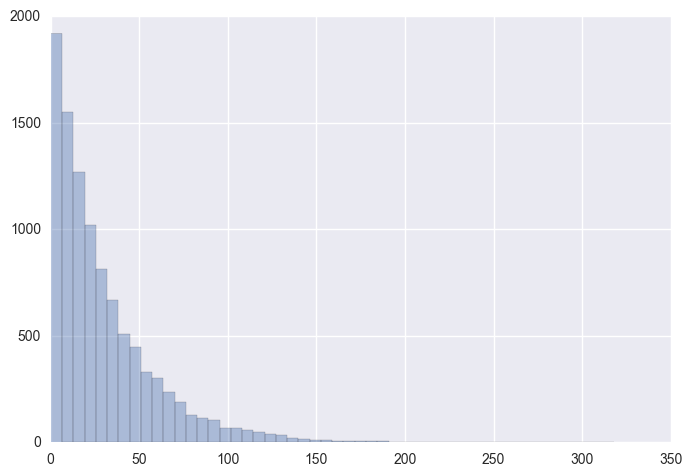

In [8]:
with model:
    """
    Prior for ν is an exponential (lambda=29) shifted +1.
    """
    ν = pm.Exponential('ν_min_one', 1/29.) + 1

sns.distplot(np.random.exponential(30, size=10000), kde=False);

In [9]:
with model:
    """
    Transforming standard deviations to precisions (1/variance) before
    specifying likelihoods.
    """
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('group1', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('group2', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

Now we'll look at the difference between group means and group standard deviations.

In [10]:
with model:
    """
    The effect size is the difference in means/pooled estimates of the standard deviation.
    The Deterministic class represents variables whose values are completely determined
    by the values of their parents.
    """
    diff_of_means = pm.Deterministic('difference of means',  group2_mean - group1_mean)
    diff_of_stds = pm.Deterministic('difference of stds',  group2_std - group1_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group2_std**2 + group1_std**2) / 2))

In [11]:
with model:
    trace = pm.sample(2000, njobs=2)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_min_one_log_
 [-----------------100%-----------------] 2000 of 2000 complete in 10.7 sec

### Summarize the posterior distributions of the parameters.

Let's look at the group differences (group2_mean = group1_mean), setting ref_val=0, which displays the percentage below and above zero.

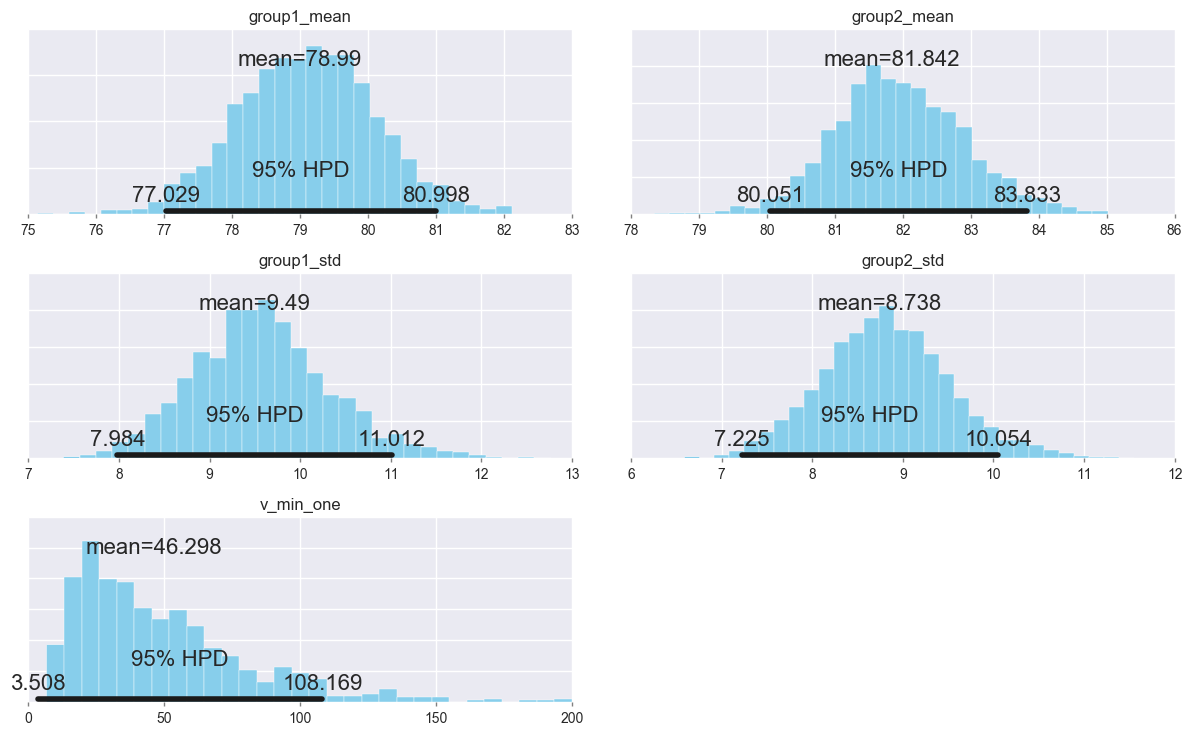

In [12]:
pm.plot_posterior(trace[1000:],
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std', 'ν_min_one'],
                  color='#87ceeb');

For the difference in means, 1.9% of the posterior probability is less than zero, while 98.1% is greater than zero. 

In other words, there is a very small chance that the mean for group1 is larger or equal to the mean for group2, but there a much larger chance that group2's mean is larger than group1's.

It also looks like the variability in scores for group2 was somewhat lower than for group1- perhaps switching the order that genetics was taught not only increased scores, but brought some of the outlier students (particularly the ones that would have scored most poorly) closer to the mean? 

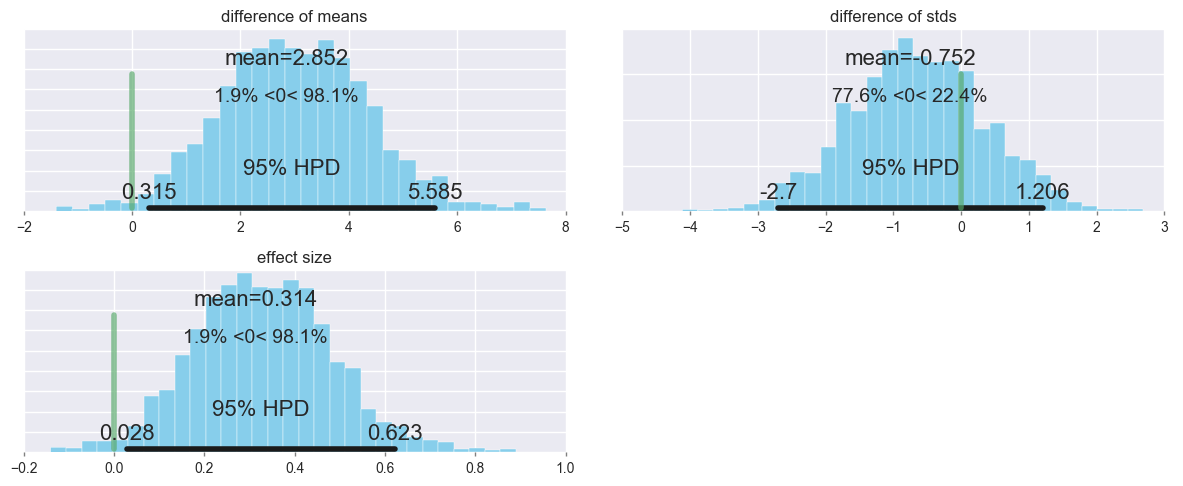

In [13]:
pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');